## imports

In [ ]:
!pip install datasets transformers rouge-score nltk

import datasets
from datasets import Dataset
from datasets import load_dataset, load_metric

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [ ]:
import torch
from transformers import AutoTokenizer,T5Tokenizer, T5ForConditionalGeneration
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

## load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_news = pd.read_csv('/content/drive/MyDrive/NLP/Project/news_summary.csv', encoding = "ISO-8859-1", engine='python')
print(df_news.shape)
df_news.head()

(4514, 6)


,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [ ]:
df_news = df_news[['headlines', 'text', 'ctext']]
df_news.head()

,headlines,text,ctext
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


## preprocessing data

In [ ]:
# clean data
def clean_df(df):
  # remove email starts
  df.text = df.text.replace(re.compile(r"From|\S*@\S*\s?|Subject"), "")

  # remove extra spaces
  df.text = df.text.replace(re.compile("\s+"), " ")

  # remove -, _ and :
  df.text = df.text.replace(re.compile("[\-_,;:]"), " ")

  # remove other chars
  df.text = df.text.replace(re.compile("[^a-zA-Z0-9\.,$# ]"), "")

  df.text = df.text.apply(lambda x: x.strip())

  return df


In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  4514 non-null   object
 1   text       4514 non-null   object
 2   ctext      4396 non-null   object
dtypes: object(3)
memory usage: 105.9+ KB


In [ ]:
# dropping rows with null ctext
df_news = df_news.dropna()
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 0 to 4513
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  4396 non-null   object
 1   text       4396 non-null   object
 2   ctext      4396 non-null   object
dtypes: object(3)
memory usage: 137.4+ KB


In [ ]:
# joining headline + main text to get full_text
df_news['full_text'] = df_news[['headlines', 'ctext']].apply(lambda x: ' '.join(x), axis=1)

df_news.rename(columns={"text": "summary", "headlines": "headline"}, inplace=True)
df_news.drop(columns=['ctext'], inplace=True)
df_news.shape

(4396, 3)

In [ ]:
display(HTML(df_news.sample(3).to_html()))

,headline,summary,full_text
2842,Man loses arm fighting a crocodile to save dogs,"A 26-year-old entered a restricted forest area of Karnataka's Thattekere Lake and lost his arm in an attack by a crocodile while trying to help his two dogs out of the lake. The incident happened when the IIT graduate, who is also a CEO of a startup, was out on a trekking expedition along with a friend and his dogs.","Man loses arm fighting a crocodile to save dogs Forest has rules. Unsaid yet well known. You dare to break the rules of the forest, you pay for it.The Founder and CEO of Turtle Shell Technologies, a startup based out of Bengaluru -- Mudit Dandwate -- chose to enter a restricted area of Bengaluru's Thattekere Lake in Ramanagara district. The lake is at least 46 km from Bengaluru. The IIT graduate, 26, was attacked by a crocodile when he tried to help his two dogs out of the lake. Dandwate, originally from Nagpur, was out on a trekking expedition, along with a friend and two pet dogs. THE CROCODILE ATTACKDandwate's dogs, excited to see a water body, jumped into the lake. Mudit, worried about his dogs, jumped into the lake to help them out of the water but failed to notice the signboard that warned of the presence of crocodiles in the lake. As he was helping his dogs out, a crocodile attacked Mudit and tore off his left arm from below the elbow, the friend told the police. Mudit was operated on at Hosmat Hospital to where he was taken to after he was rushed to a local hospital for first aid, and is recovering. TREATMENT The Times of India quoted Thomas Chandy, Chief of Orthopaedics, as saying, ""A crocodile bite is powerful and has crushed the arm, just like in the case of any industrial accident. But crocodile bite is toxic as well. So we are currently performing medical procedure called debridement, where is hand is being cleaned several time to make sure there is no infection.""A report on India.com said that the chances of Mudit regaining his arm are bleak and that the doctors said he would be given a prosthetic arm in another three months."
132,Two accused in Dadri mob lynching case get bail,"The Allahabad High Court on Monday granted bail to two accused in the 2015 lynching of Mohammad Akhlaq in Dadri for allegedly slaughtering a cow. A local BJP leader, who is the father of one of the accused who got bail, praised the BJP for providing justice to his son. Notably, 14 people have been granted bail in the case.","Two accused in Dadri mob lynching case get bail Vishal Rana (21) and Hari Om (26), accused in the 2015 lynching of Mohammad Ikhlaq in Bisada for allegedly slaughtering a cow, was granted bail by the Allahabad high court on Monday.Vishal?s father Sanjay Rana (47), a local BJP leader, said his son ?got justice? because Uttar Pradesh ?has a BJP government?.?Though government has no say in court?s decision, it ensured justice is done,? he said, and claimed that in the previous regime, officials were did not ensure fair investigation.Sanjay also claimed that ?the whole village, including Muslims, were happy over the bail of my son?.?I do not have any grouse against my Muslim brothers. I am annoyed over Ikhlaq?s family, who slaughtered a cow and later made my family victim for it. It was a mob that attacked the family and I have suffered for it,? he claimed.The case pertains to the September 28, 2015 lynching of 55-year-old Ikhlaq and the assault on his family in Bisada village near Noida by a mob on the allegation of slaughtering a cow and storing its meat for consumption. Following the incident, 18 people were taken into custody, of which 14 had gotten bail. One of the accused in jail, Ravin (22) died in police custody in October 2016, allegedly due to dengue, while his family had blamed it on torture in the jail.Vishal and Hari Om along with another accused had been in Luksar Jail of Greater Noida for the last 22 months. The duo, who got bail, would be released after two days due to legal formalities.The case had political r

### length analysis

In [ ]:
# getting length for each column
for col in df_news.columns.tolist():
    df_news[col+"_num_words"] = df_news[col].apply(lambda x: len(x.split()))
df_news.head()

,headline,summary,full_text,headline_num_words,summary_num_words,full_text_num_words
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,Daman & Diu revokes mandatory Rakshabandhan in...,9,60,373
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...,Malaika slams user who trolled her for 'divorc...,10,60,406
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...,'Virgin' now corrected to 'Unmarried' in IGIMS...,8,60,343
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Aaj aapne pakad liya: LeT man Dujana before be...,10,60,414
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...,Hotel staff to get training to spot signs of s...,11,60,537


In [ ]:
cols = ['headline_num_words','summary_num_words', 'full_text_num_words']
df_news[cols].describe()

,headline_num_words,summary_num_words,full_text_num_words
count,4396.000000,4396.000000,4396.000000
mean,9.300045,58.289354,352.367834
std,1.404141,2.316088,357.585301
min,4.000000,44.000000,12.000000
25%,8.000000,57.000000,195.000000
50%,9.000000,59.000000,292.000000
75%,10.000000,60.000000,420.000000
max,14.000000,62.000000,12212.000000


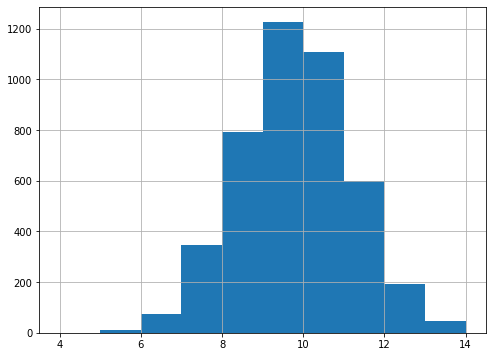

In [ ]:
df_news["headline_num_words"].hist(bins=10, figsize=(8,6))

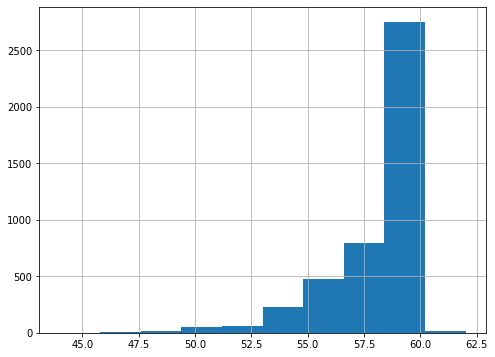

In [ ]:
df_news["summary_num_words"].hist(bins=10, figsize=(8,6))

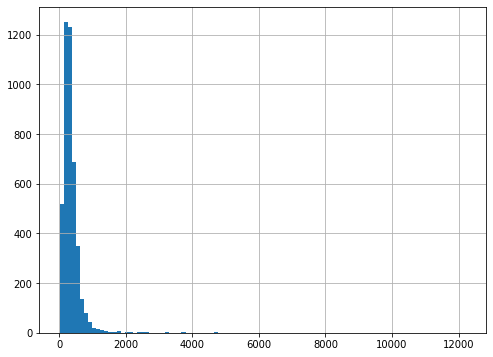

In [ ]:
df_news["full_text_num_words"].hist(bins=100, figsize=(8,6))

(0.0, 1500.0)

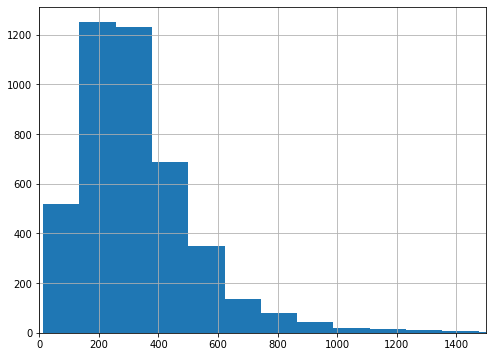

In [ ]:
# zoomed-in
axes = df_news["full_text_num_words"].hist(bins=100, figsize=(8,6))
axes.set_xlim(0, 1500)

## tokenizer

In [ ]:
# Tokenizer will tokenize the inputs by converting the tokens to their corresponding IDs in the pretrained vocabulary
# put it in a format the model expects, as well as generate the other inputs that the model requires
base_model = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(base_model)

By default, the call above will use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [ ]:
text = "Hello, this one sentence!"
tokenizer(text)

{'input_ids': [8774, 6, 48, 80, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.tokenize("Hello, this one sentence!")

['▁Hello', ',', '▁this', '▁one', '▁sentence', '!']

In [ ]:
# finds subwords until it matches with what's in its vocab
tokenizer.tokenize("This ios is asfsfsfsdf wikiapple.")

['▁This',
 '▁',
 'i',
 'o',
 's',
 '▁is',
 '▁as',
 'f',
 's',
 'f',
 's',
 'f',
 's',
 'd',
 'f',
 '▁',
 'wiki',
 'app',
 'le',
 '.']

In [ ]:
tokenizer.encode([ctext], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')

In [ ]:
len(tokenizer.vocab)

32100

In [ ]:
print(tokenizer.vocab)

{'▁Unlimited': 24813, '▁discut': 8597, '▁cauta': 18544, '▁Fran': 8177, '▁Main': 5140, '▁editorial': 14829, '▁exceptionnel': 28975, '▁marketing': 1070, 'top': 2916, '▁Securities': 20571, '▁Provide': 7740, '▁floors': 8242, 'espoir': 26299, 'étaient': 9998, '▁Münster': 30055, 'ogram': 16275, 'point': 2700, 'ов': 16811, '▁sans': 1532, '▁peur': 20581, 'Survivor': 31400, '210': 15239, '▁Apache': 24263, '▁versehen': 28691, 'view': 4576, 'litz': 13668, '▁herb': 14771, '▁Elvis': 28132, 'biz': 19000, '▁soluţi': 22436, '▁encouraged': 6470, '▁(2014)': 24373, '▁downstream': 26804, '▁Wall': 3556, '▁Should': 5066, '▁requested': 6709, '▁injection': 10672, 'nah': 8607, 'mind': 14481, '▁congregation': 17368, '▁Americans': 5452, '<extra_id_4>': 32095, '▁submarine': 28158, '(2000)': 31804, '▁Marg': 16409, '▁fly': 3971, '▁civil': 3095, '▁learned': 2525, 'cured': 26867, 'dirigé': 31737, '▁père': 17280, 'izo': 14406, '▁know': 214, '▁navy': 23118, '▁asleep': 17915, 'suited': 10967, '▁porte': 5137, 'yton': 212

In [ ]:
# pass list of sentences
tokenized_sample = tokenizer(["Hello, this one sentence!", "This is another sentence."])
print(tokenized_sample)

# check keys within tokenizer output
print(tokenized_sample.keys())

print(tokenized_sample['input_ids'])
print(tokenized_sample['attention_mask'])

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}
dict_keys(['input_ids', 'attention_mask'])
[[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]]
[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]


In [ ]:
# To prepare the targets for our model, we need to tokenize them inside the `as_target_tokenizer` context manager 
# This will make sure the tokenizer uses the special tokens corresponding to the targets
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


## prep data for model

In [ ]:
# if out base model is T5 based, we have to prefix the inputs with "summarize:" 
# the prefix tells model which task to perform (as model can also do translation task)
prefix = "summarize: "

max_input_length = 600
max_target_length = 100

# data has full_text and summary
def preprocess_function(data):
    full_texts = [prefix + doc for doc in data['full_text']]

    # padding will be dealt with data collator, so we pad examples to the longest length in the batch and not the whole dataset.
    model_inputs = tokenizer(full_texts, max_length=max_input_length, truncation=True)

    # setup the tokenizer for summary
    with tokenizer.as_target_tokenizer():
        summary = tokenizer(data['summary'], max_length=max_target_length, truncation=True)

    # for summary we don't need attention mask
    # model_inputs will have input_ids and attention mask of full text, input_ids (which we store as labels) of summary 
    model_inputs["labels"] = summary["input_ids"]
    return model_inputs

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [ ]:
 # split data into train/test
 df_train, df_test = train_test_split(df_news, test_size=0.20, random_state=42)
 df_train.shape, df_test.shape

((3516, 3), (880, 3))

In [ ]:
# dataset object for train/test: makes it easier to access batch of data
dataset_train = Dataset.from_pandas(df_train[['full_text', 'summary']])
dataset_test = Dataset.from_pandas(df_test[['full_text', 'summary']])

len(dataset_train), len(dataset_test)

(3516, 880)

In [ ]:
dataset_train[0]

{'__index_level_0__': 4348,
 'full_text': 'Parents will not name their sons Akhilesh now: Adityanath BJP MP Yogi Adityanath has likened Uttar Pradesh Chief Minister Akhilesh Yadav with \'Aurangzeb\' and \'Kans\', saying parents will now desist from naming their sons Akhilesh."Akhilesh did what \'Aurangzeb\' and \'Kans\' did not do. Due to his deeds, parents will now desist from naming their sons Akhilesh", he said at an election meeting in Bhadohi."Akhilesh is now saying that he would develop the state in next five years, if given a chance, but what was he doing in the past five years?" he asked.Aurangzeb was a controversial Mughal ruler, while the mythological character of Kans is considered the tyrant ruler of Vrishni kingdom with its capital at Mathura.UP GOVT PATRONISED TERRORISTS: ADITYANATHThe firebrand BJP MP from Gorakhpur said the state government patronised terrorists, anti-socials and rapists."Whatever scheme the government ran, it was only for a particular community," he al

In [ ]:
preprocess_function(dataset_train[:1])

{'input_ids': [[21603, 10, 15921, 56, 59, 564, 70, 520, 7, 71, 29392, 965, 107, 230, 10, 1980, 155, 21247, 189, 3, 28065, 5220, 6545, 122, 23, 1980, 155, 21247, 189, 65, 114, 29, 15, 26, 31251, 22660, 5116, 3271, 71, 29392, 965, 107, 4701, 26, 9, 208, 28, 3, 31, 188, 76, 6287, 776, 115, 31, 11, 3, 31, 439, 3247, 31, 6, 2145, 1362, 56, 230, 93, 343, 45, 3, 21990, 70, 520, 7, 71, 29392, 965, 107, 535, 188, 29392, 965, 107, 410, 125, 3, 31, 188, 76, 6287, 776, 115, 31, 11, 3, 31, 439, 3247, 31, 410, 59, 103, 5, 6984, 12, 112, 20, 15, 26, 7, 6, 1362, 56, 230, 93, 343, 45, 3, 21990, 70, 520, 7, 71, 29392, 965, 107, 1686, 3, 88, 243, 44, 46, 4356, 1338, 16, 272, 8399, 32, 107, 23, 535, 188, 29392, 965, 107, 19, 230, 2145, 24, 3, 88, 133, 1344, 8, 538, 16, 416, 874, 203, 6, 3, 99, 787, 3, 9, 1253, 6, 68, 125, 47, 3, 88, 692, 16, 8, 657, 874, 203, 4609, 3, 88, 1380, 5, 188, 76, 6287, 776, 115, 47, 3, 9, 15202, 283, 14439, 138, 21893, 6, 298, 8, 9735, 4478, 1848, 13, 4540, 7, 19, 1702, 8, 3, 17

In [ ]:
dataset_train[:3]

{'__index_level_0__': [4348, 4446, 542],
 'full_text': ['Parents will not name their sons Akhilesh now: Adityanath BJP MP Yogi Adityanath has likened Uttar Pradesh Chief Minister Akhilesh Yadav with \'Aurangzeb\' and \'Kans\', saying parents will now desist from naming their sons Akhilesh."Akhilesh did what \'Aurangzeb\' and \'Kans\' did not do. Due to his deeds, parents will now desist from naming their sons Akhilesh", he said at an election meeting in Bhadohi."Akhilesh is now saying that he would develop the state in next five years, if given a chance, but what was he doing in the past five years?" he asked.Aurangzeb was a controversial Mughal ruler, while the mythological character of Kans is considered the tyrant ruler of Vrishni kingdom with its capital at Mathura.UP GOVT PATRONISED TERRORISTS: ADITYANATHThe firebrand BJP MP from Gorakhpur said the state government patronised terrorists, anti-socials and rapists."Whatever scheme the government ran, it was only for a particular com

In [ ]:
preprocess_function(dataset_train[:3])

{'input_ids': [[21603, 10, 15921, 56, 59, 564, 70, 520, 7, 71, 29392, 965, 107, 230, 10, 1980, 155, 21247, 189, 3, 28065, 5220, 6545, 122, 23, 1980, 155, 21247, 189, 65, 114, 29, 15, 26, 31251, 22660, 5116, 3271, 71, 29392, 965, 107, 4701, 26, 9, 208, 28, 3, 31, 188, 76, 6287, 776, 115, 31, 11, 3, 31, 439, 3247, 31, 6, 2145, 1362, 56, 230, 93, 343, 45, 3, 21990, 70, 520, 7, 71, 29392, 965, 107, 535, 188, 29392, 965, 107, 410, 125, 3, 31, 188, 76, 6287, 776, 115, 31, 11, 3, 31, 439, 3247, 31, 410, 59, 103, 5, 6984, 12, 112, 20, 15, 26, 7, 6, 1362, 56, 230, 93, 343, 45, 3, 21990, 70, 520, 7, 71, 29392, 965, 107, 1686, 3, 88, 243, 44, 46, 4356, 1338, 16, 272, 8399, 32, 107, 23, 535, 188, 29392, 965, 107, 19, 230, 2145, 24, 3, 88, 133, 1344, 8, 538, 16, 416, 874, 203, 6, 3, 99, 787, 3, 9, 1253, 6, 68, 125, 47, 3, 88, 692, 16, 8, 657, 874, 203, 4609, 3, 88, 1380, 5, 188, 76, 6287, 776, 115, 47, 3, 9, 15202, 283, 14439, 138, 21893, 6, 298, 8, 9735, 4478, 1848, 13, 4540, 7, 19, 1702, 8, 3, 17

In [ ]:
# apply preprocess_function to all elems of dataset train/test object
# batched=True to encode the texts by batches together
# this also caches the results to avoid spending time on this step the next time we run the code
# we can pass load_from_cache_file=False inside map(...) to not use the cached files and force the preprocessing to be applied again

dataset_train_tokenized = dataset_train.map(preprocess_function, batched=True)
dataset_test_tokenized = dataset_test.map(preprocess_function, batched=True)

In [ ]:
len(dataset_train_tokenized), len(dataset_test_tokenized)

(3516, 880)

In [ ]:
# input_ids, attention_mask is for full_text
# labels is for summary
print(dataset_train_tokenized[0].keys())
print(dataset_train_tokenized[0])

dict_keys(['__index_level_0__', 'attention_mask', 'full_text', 'input_ids', 'labels', 'summary'])
{'__index_level_0__': 4348, 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

## fine-tuning the model

In [ ]:
# load rouge metric
metric = load_metric("rouge")

# load t5-base model
model_summ = AutoModelForSeq2SeqLM.from_pretrained(base_model)

### o/p check before finetuning

In [ ]:
def get_summary(summarizer_object, text, min_length=10, max_length=100):
    summary = [elem['summary_text'] for elem in summarizer_object(text, min_length=min_length, max_length=max_length)]
    display(HTML(pd.DataFrame({"text":text, "summary":summary}).to_html()))

In [ ]:
# pass finetuned model and tokenizer
# device=0 is gpu
summarizer_before_train = pipeline("summarization", model=model_summ, tokenizer=tokenizer, device=0)

In [ ]:
# returns a list of dict with summary 
summarizer_before_train(["This is quite good. Hello World", "This is quite good"], min_length=3, max_length=3)

[{'summary_text': 'Hello World'}, {'summary_text': 'This is'}]

In [ ]:
get_summary(summarizer_before_train, df_train[:1].full_text.tolist())

,text,summary
0,"Parents will not name their sons Akhilesh now: Adityanath BJP MP Yogi Adityanath has likened Uttar Pradesh Chief Minister Akhilesh Yadav with 'Aurangzeb' and 'Kans', saying parents will now desist from naming their sons Akhilesh.""Akhilesh did what 'Aurangzeb' and 'Kans' did not do. Due to his deeds, parents will now desist from naming their sons Akhilesh"", he said at an election meeting in Bhadohi.""Akhilesh is now saying that he would develop the state in next five years, if given a chance, but what was he doing in the past five years?"" he asked.Aurangzeb was a controversial Mughal ruler, while the mythological character of Kans is considered the tyrant ruler of Vrishni kingdom with its capital at Mathura.UP GOVT PATRONISED TERRORISTS: ADITYANATHThe firebrand BJP MP from Gorakhpur said the state government patronised terrorists, anti-socials and rapists.""Whatever scheme the government ran, it was only for a particular community,"" he alleged.Listing out the work which the BJP would do if voted to power, Adityanath said, ""We will promote traditional industries and send bangles to Akhilesh and Rahul Gandhi from Firozabad bangle industry and constitute anti-Romeo squad for UP minister Azam Khan.""He said a BJP government in Uttar Pradesh will pave way for Ram temple and that money will be spent on development.FINAL PHASE OF CAMPAIGNING ENDED ON MONDAY","parents will not name their sons Akhilesh now, a BJP MP says . he likens 'Aurangzeb' and 'Kans' to 'kans' he says he would develop the state in next five years ."


In [ ]:
get_summary(summarizer_before_train, df_test[:1].full_text.tolist())

,text,summary
0,"Woman arrested three times for trying to jump fence near WH Washington, Mar 27 (PTI) A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. Marci Anderson Wahl of Everett, Washington, was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the Treasury Building, next to the White House. Police said Wahl has told them she was there to speak to US President Donald Trump, the CNN reported. She was charged with unlawful entry and contempt of court. Wahl was first arrested on March 21 last week for trying to jump the White House fence. Once in custody, it was determined that Wahl had been issued a ""stay away"" order for the White House complex after the incident. On March 21, officers saw Wahl walking and staring at the White House complex before discovering she had jumped a fence on the south side but got stuck. Officers found her hanging from the inside of the fence by her shoelaces, which were ""caught on top of the fence,"" according to a police report. She was re-arrested on March 24 after officers saw her near Lafayette Park. She was released on her own recognisance after a Saturday court appearance. In the incident, Wahl was charged with contempt of court in violation of a stay away order. She pleaded not guilty last Saturday and was again released on her own recognisance.",a 38-year-old woman in the u.s. was arrested for trying to jump fence near WH Washington . she was arrested after an alarm sounded at about 2:15 am yesterday . police said she has told them she was there to speak to president .


### training

In [ ]:
# to instantiate a `Seq2SeqTrainer`, we will need to define three more things. 
# [`Seq2SeqTrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), 
# which is a class that contains all the attributes to customize the training. 
# It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

# explain some params in report
# moddel takes batch of sample -> make prediction -> calculate loss -> update weight

# Some arguments are not directly used by ~transformers.Trainer, rather used by your training/evaluation scripts instead

# do_train (bool, optional, defaults to False) – Whether to run training or not
# do_eval (bool, optional) – Whether to run evaluation on the validation set or not
    # Will be set to True if evaluation_strategy is different from "no".
# do_predict (bool, optional, defaults to False) – Whether to run predictions on the test set or not

# evaluation_strategy (defaults to "no"): The evaluation strategy to adopt during training. Possible values are
    #  * `"no"`: No evaluation is done during training.
    #  * `"steps"`: Evaluation is done (and logged) every `eval_steps`.
    #  * `"epoch"`: Evaluation is done at the end of each epoch.


# eval_steps (int, optional) – Number of update steps between two evaluations if evaluation_strategy="steps". 
        # will default to the same value as logging_steps if not set.

# logging_strategy: defaults to "steps
# logging_steps (int, optional, defaults to 500) – Number of update steps between two logs if logging_strategy="steps"

# save_strategy: defaults to "steps"
# save_steps (int, optional, defaults to 500): number of updates steps before two checkpoint saves if save_strategy="steps"
# save_total_limit= will limit the total amount of checkpoints. Deletes the older checkpoints 

# learning_rate (float, optional, defaults to 5e-5): The initial learning rate for ~transformers.AdamW optimizer.
# weight_decay (float, optional, defaults to 0): The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in

# fp16: Whether to use 16-bit (mixed) precision training instead of 32-bit training, helps to train faster

# load_best_model_at_end: by default loads best model based on loss
   # when set to True, the parameters save_strategy and save_steps will be ignored and the model will be saved after each evaluation
# metric_for_best_model
# resume_from_checkpoint

# predict_with_generate: whether to use generate to calculate generative metrics

"""
batch_size = 16
args = Seq2SeqTrainingArguments(
    "test-summarization",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
)
"""

batch_size = 8
epochs = 3

args = Seq2SeqTrainingArguments("summarization_t5_v2", num_train_epochs=epochs,
                                # we will evaluate after every 100 batch (100*8 = 800 samples)
                                evaluation_strategy = "epoch", logging_steps = 100,
                                learning_rate=2e-5, weight_decay=0.01,
                                per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size,
                                # max number of times to save model
                                save_total_limit=3, predict_with_generate=True, fp16=True, 
                                load_best_model_at_end = True, 
                                )


In [ ]:
# calculate rouge scores
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
# will pad the inputs and the labels to maximum length in a batch
# so we pad examples to the longest length in the batch and not the whole dataset
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_summ)

"""
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
"""

model_trainer = Seq2SeqTrainer(model_summ, args,
                               train_dataset = dataset_train_tokenized, eval_dataset = dataset_test_tokenized,
                               data_collator = data_collator, tokenizer = tokenizer, compute_metrics = compute_metrics)

In [ ]:
# train the model
model_trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.023800,1.778518,46.315600,23.789900,33.781800,41.359200,83.285200
2,1.896700,1.748661,47.149400,24.739300,34.678600,42.225900,85.055700
3,1.930700,1.740705,47.557600,25.109600,35.009500,42.609900,85.629500


TrainOutput(global_step=1320, training_loss=1.966799039551706, metrics={'train_runtime': 2067.3325, 'train_samples_per_second': 0.639, 'total_flos': 0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 4096, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 9138176, 'train_mem_gpu_alloc_delta': 741037056, 'train_mem_cpu_peaked_delta': 5201920, 'train_mem_gpu_peaked_delta': 3462683648})

In [ ]:
# results for previous run
scores = {'Training Loss': [2.2211, 2.0252, 2.0031, 2.0235, 1.9403, 1.9598, 1.9417, 1.8935, 1.9294, 1.8714, 1.9054, 1.9167, 1.9252], 
          'Validation Loss': [1.901903, 1.830108, 1.798404, 1.784771, 1.772367, 1.759735, 1.757113, 1.750193, 1.747493, 1.74605, 1.743051, 1.741059, 1.740497], 
          'Rouge1': [44.6989, 45.0498, 45.0502, 45.3305, 45.2789, 45.4722, 45.5978, 45.6992, 45.6578, 45.7168, 45.7089, 45.6965, 45.7181], 
          'Rouge2': [21.6698, 22.0926, 22.1557, 22.5228, 22.5419, 22.8009, 22.9777, 23.1056, 23.1197, 23.1844, 23.1497, 23.2195, 23.2356], 
          'Rougel': [32.356, 32.6704, 32.6976, 32.9167, 32.865, 33.0508, 33.1871, 33.2456, 33.2603, 33.345, 33.3058, 33.3256, 33.332], 
          'Rougelsum': [39.6232, 39.8603, 39.9352, 40.2212, 40.2205, 40.4183, 40.5925, 40.6514, 40.6369, 40.6908, 40.6836, 40.7002, 40.7068], 
          'Gen Len': [81.4908, 81.4908, 81.4919, 81.4919, 81.4919, 81.4931, 81.4976, 81.4976, 81.4976, 81.4976, 81.4976, 81.4976, 81.4976]
          }

df_scores = pd.DataFrame(scores)
df_scores

,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,2.2211,1.901903,44.6989,21.6698,32.3560,39.6232,81.4908
1,2.0252,1.830108,45.0498,22.0926,32.6704,39.8603,81.4908
2,2.0031,1.798404,45.0502,22.1557,32.6976,39.9352,81.4919
3,2.0235,1.784771,45.3305,22.5228,32.9167,40.2212,81.4919
4,1.9403,1.772367,45.2789,22.5419,32.8650,40.2205,81.4919
5,1.9598,1.759735,45.4722,22.8009,33.0508,40.4183,81.4931
6,1.9417,1.757113,45.5978,22.9777,33.1871,40.5925,81.4976
7,1.8935,1.750193,45.6992,23.1056,33.2456,40.6514,81.4976
8,1.9294,1.747493,45.6578,23.1197,33.2603,40.6369,81.4976
9,1.8714,1.746050,45.7168,23.1844,33.3450,40.6908,81.4976


### plot results

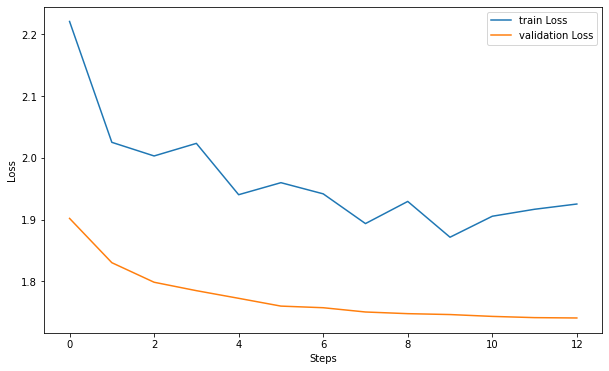

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(scores['Training Loss'], label="train Loss")
plt.plot(scores['Validation Loss'], label="validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

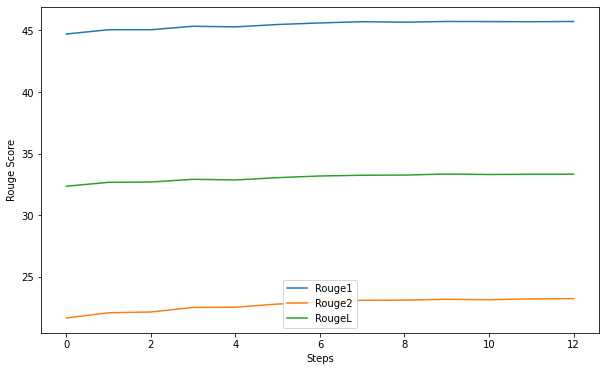

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(scores['Rouge1'], label="Rouge1")
plt.plot(scores['Rouge2'], label="Rouge2")
plt.plot(scores['Rougel'], label="RougeL")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()

## predictions

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
# pass finetuned model and tokenizer
summarizer = pipeline("summarization", model=model_summ, tokenizer=tokenizer, device=0)

In [ ]:
idx = random.sample(range(0, len(df_news)), k=3)
get_summary(summarizer, df_news.iloc[idx].full_text.tolist())

,text,summary
0,"England players take London Tube to reach Test match venue Before they consolidated their hold on the ongoing third Test at The Oval against South Africa, a few of England cricketers took the underground tube in London to reach the ground which is hosting his record 100th Test match, on Saturday.On a rain-truncated third day of the ongoing third Test, England shot South Africa out for a mere 175, and by the time the play was stopped, the hosts had accumulated an overall lead of 252 runs with nine wickets intact in their second essay.READ | Toby Roland-Jones joins elite England club after heroics against South AfricaEngland had posted an at-par total of 353 in their first innings, and seized control of the Test when debutant Toby Roland-Jones wreaked havoc in the South African ranks, claiming 5 for 57.Roland-Jones was in that bunch of cricketers who on Saturday morning took the London tube from the Bank Station. England captain Joe Root, Stuart Broad, James Anderson, and Jonny Bairstow were among those who took the train like the common London commuter to his workplace.#morningcommute @StuartBroad8 not awkward at all. pic.twitter.com/0uKohIGfRX? Joe Root (@root66) July 29, 2017As they waited for the train to arrive, Broad looked content at an advertisement poster in front of him for UK broadcaster Sky Sports. Broad posted on Instagram about the train travel with his teammates. #morningcommute #london Off to the Test! ?? A post shared by Stuart Broad (@stuartbroad8) on Jul 29, 2017 at 1:03am PDT While Root and Broad posted on social media about their travel in the tube, there was one man who seemingly enjoyed the journey without actually being there. It was Alex Hales.You can even see the smug look of self-satisfaction from behind him pic.twitter.com/pSm7LKMIXO? Alex Hales (@AlexHales1) July 29, 2017Almost as smug as this one! pic.twitter.com/QvfhdjSyrb? Alex Hales (@AlexHales1) July 29, 2017England were 74 for 1 in their second innings, with Keaton Jennings (34) and Tom Westley (28) at the crease.","England players took the tube from the London tube to reach the site for the 100th Test match against South Africa on Saturday. On a rain-truncated third day of the ongoing third Test, England shot South Africa out for a mere 175, and by the time the play was stopped, the hosts had accumulated an overall lead of 252 runs with nine wickets intact."
1,"BJP leader moves EC against Mayawati for 'caste politics' Lucknow, Jan 9 (PTI) A BJP leader has moved the Election Commission against BSP chief Mayawati accusing her of seeking votes in the name of caste and demanded that her party be debarred from contesting elections. BJPs UP executive member Neeraj Shankar Saxena moved a petition against Mayawati on Saturday demanding that her party be debarred from contesting polls and filing of FIR against her for ""flouting"" Supreme Court directives. ""Mayawati during her press conference on December 24 and January 3 presented caste-wise details of ticket distribution clearly stating that her party has given tickets to how many Muslims, backwards, SCs and others,"" Saxena told PTI.","A BJP leader has moved the Election Commission against BSP chief Mayawati accusing her of seeking votes in the name of caste and demanded that her party be debarred from contesting elections. BJPs UP executive member Neeraj Shankar Saxena has moved a petition against her accusing she of 'flouting' FIR against her for ""frouting"" Supreme Court directives."
2,"UP CM wants pics of teachers to be pasted on school walls In a bid to improve education quality in state-run schools and ensure regular attendance, Uttar Pradesh Chief Minister Yogi Adityanath wants pictures of faculty members pasted on school walls.This will be done to check and then cross-check from the students whether those whose pictures were displayed attend schools regularly and teach or not.Yogi Adityanath took the decision at a meeting in Gorakhpur on Sunday. STANDARD OF SCHOOLS A WORRY

### compare with before finetuned

In [ ]:
get_summary(summarizer_before_train, df_train[:1].full_text.tolist())

,text,summary
0,"Parents will not name their sons Akhilesh now: Adityanath BJP MP Yogi Adityanath has likened Uttar Pradesh Chief Minister Akhilesh Yadav with 'Aurangzeb' and 'Kans', saying parents will now desist from naming their sons Akhilesh.""Akhilesh did what 'Aurangzeb' and 'Kans' did not do. Due to his deeds, parents will now desist from naming their sons Akhilesh"", he said at an election meeting in Bhadohi.""Akhilesh is now saying that he would develop the state in next five years, if given a chance, but what was he doing in the past five years?"" he asked.Aurangzeb was a controversial Mughal ruler, while the mythological character of Kans is considered the tyrant ruler of Vrishni kingdom with its capital at Mathura.UP GOVT PATRONISED TERRORISTS: ADITYANATHThe firebrand BJP MP from Gorakhpur said the state government patronised terrorists, anti-socials and rapists.""Whatever scheme the government ran, it was only for a particular community,"" he alleged.Listing out the work which the BJP would do if voted to power, Adityanath said, ""We will promote traditional industries and send bangles to Akhilesh and Rahul Gandhi from Firozabad bangle industry and constitute anti-Romeo squad for UP minister Azam Khan.""He said a BJP government in Uttar Pradesh will pave way for Ram temple and that money will be spent on development.FINAL PHASE OF CAMPAIGNING ENDED ON MONDAY","parents will not name their sons Akhilesh now, a BJP MP says . he likens 'Aurangzeb' and 'Kans' to 'kans' he says he would develop the state in next five years ."


In [ ]:
get_summary(summarizer, df_train[:1].full_text.tolist())

,text,summary
0,"Parents will not name their sons Akhilesh now: Adityanath BJP MP Yogi Adityanath has likened Uttar Pradesh Chief Minister Akhilesh Yadav with 'Aurangzeb' and 'Kans', saying parents will now desist from naming their sons Akhilesh.""Akhilesh did what 'Aurangzeb' and 'Kans' did not do. Due to his deeds, parents will now desist from naming their sons Akhilesh"", he said at an election meeting in Bhadohi.""Akhilesh is now saying that he would develop the state in next five years, if given a chance, but what was he doing in the past five years?"" he asked.Aurangzeb was a controversial Mughal ruler, while the mythological character of Kans is considered the tyrant ruler of Vrishni kingdom with its capital at Mathura.UP GOVT PATRONISED TERRORISTS: ADITYANATHThe firebrand BJP MP from Gorakhpur said the state government patronised terrorists, anti-socials and rapists.""Whatever scheme the government ran, it was only for a particular community,"" he alleged.Listing out the work which the BJP would do if voted to power, Adityanath said, ""We will promote traditional industries and send bangles to Akhilesh and Rahul Gandhi from Firozabad bangle industry and constitute anti-Romeo squad for UP minister Azam Khan.""He said a BJP government in Uttar Pradesh will pave way for Ram temple and that money will be spent on development.FINAL PHASE OF CAMPAIGNING ENDED ON MONDAY","BJP MP Yogi Adityanath has likened Uttar Pradesh Chief Minister Akhilesh Yadav with 'Aurangzeb' and 'Kans', saying parents will now desist from naming their sons. ""We will promote traditional industries and send bangles to Akhileh and Rahul Gandhi from Firozabad Bangle Industry and constitute anti-Romeo squad for UP minister Azam"


In [ ]:
get_summary(summarizer_before_train, df_test[:1].full_text.tolist())

,text,summary
0,"Woman arrested three times for trying to jump fence near WH Washington, Mar 27 (PTI) A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. Marci Anderson Wahl of Everett, Washington, was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the Treasury Building, next to the White House. Police said Wahl has told them she was there to speak to US President Donald Trump, the CNN reported. She was charged with unlawful entry and contempt of court. Wahl was first arrested on March 21 last week for trying to jump the White House fence. Once in custody, it was determined that Wahl had been issued a ""stay away"" order for the White House complex after the incident. On March 21, officers saw Wahl walking and staring at the White House complex before discovering she had jumped a fence on the south side but got stuck. Officers found her hanging from the inside of the fence by her shoelaces, which were ""caught on top of the fence,"" according to a police report. She was re-arrested on March 24 after officers saw her near Lafayette Park. She was released on her own recognisance after a Saturday court appearance. In the incident, Wahl was charged with contempt of court in violation of a stay away order. She pleaded not guilty last Saturday and was again released on her own recognisance.",a 38-year-old woman in the u.s. was arrested for trying to jump fence near WH Washington . she was arrested after an alarm sounded at about 2:15 am yesterday . police said she has told them she was there to speak to president .


In [ ]:
get_summary(summarizer, df_test[:1].full_text.tolist())

,text,summary
0,"Woman arrested three times for trying to jump fence near WH Washington, Mar 27 (PTI) A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. Marci Anderson Wahl of Everett, Washington, was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the Treasury Building, next to the White House. Police said Wahl has told them she was there to speak to US President Donald Trump, the CNN reported. She was charged with unlawful entry and contempt of court. Wahl was first arrested on March 21 last week for trying to jump the White House fence. Once in custody, it was determined that Wahl had been issued a ""stay away"" order for the White House complex after the incident. On March 21, officers saw Wahl walking and staring at the White House complex before discovering she had jumped a fence on the south side but got stuck. Officers found her hanging from the inside of the fence by her shoelaces, which were ""caught on top of the fence,"" according to a police report. She was re-arrested on March 24 after officers saw her near Lafayette Park. She was released on her own recognisance after a Saturday court appearance. In the incident, Wahl was charged with contempt of court in violation of a stay away order. She pleaded not guilty last Saturday and was again released on her own recognisance.","A 38-year-old woman in the US has been arrested for allegedly trying to jump the White House fence near WH Washington, Mar 27. An alarm sounded at about 2:15 am when she scaled a fence at the Treasury Building. She was charged with unlawful entry and contempt of court."


## save and load model

In [ ]:
PATH = '/content/drive/MyDrive/NLP/summ_models/' + "model_epoch3_latest"

In [ ]:
if not os.path.isdir(PATH):
    os.mkdir(PATH)
    model_summ.save_pretrained(PATH)
else:
    print("there is already a model at this path!!!")

In [ ]:
!ls -lha /content/drive/MyDrive/NLP/summ_models/model_epoch3

total 231M
-rw------- 1 root root 1.6K May 18 12:47 config.json
-rw------- 1 root root 231M May 18 12:47 pytorch_model.bin


In [ ]:
!ls -lha /content/drive/MyDrive/NLP/summ_models/model_epoch3_latest

total 231M
-rw------- 1 root root 1.6K May 23 10:21 config.json
-rw------- 1 root root 231M May 23 10:21 pytorch_model.bin


In [ ]:
# loading finetuned model
model_summ_loaded = AutoModelForSeq2SeqLM.from_pretrained(PATH)

# creating summarizer object using loaded model
summarizer_loaded = pipeline("summarization", model=model_summ_loaded, tokenizer=tokenizer, device=0)

In [ ]:
get_summary(summarizer_loaded, df_train[1:2].full_text.tolist())

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


,text,summary
0,"10 supercars seized in Chennai for illegal racing While 10 super cars were seized from near Akkarai on East Coast Road on Sunday evening for violating traffic, deeper investigations have revealed the story of a traffic policeman who defied norms and stood against the VIP culture. Following the incident, an FIR was filed against 10 persons. The accused were also booked for rash driving, obstructing public servant and hindering him from conducting his duty. ""Apparently, a traffic unit detected the 10 Supercars grouping near VGP, ECR for a rally and informed the control room. Another team detected the speed of the vehicle near Akkarai which exceeded 180km/hr on a stretch that was 60km/hr zone"", explained a police officer. ""What's bad is that they didn't even stop when we intercepted them at Akkarai"", he added. Traffic Inspector Soundarrajan and his team were alerted near the Uthama toll gate as the cars sped away from Akkarai. Soundarrajan, blocked the cars and cordoned them. When he asked for the documentation, the drivers were able to only give them a copy of their driver's license and refused to cooperate.TRAFFIC COP INJUREDThe situation turned ugly when a Lamborghini Aventador tried to break from line and escape. Soundarrajan jumped in front of the car to stop it. But the driver ran over Soundarrajan's foot and escaped. The driver was later identified as Raghav Krishna by the cops and an additional FIR under section 332 IPC was filed against him. Kanathur Police later tracked Raghav's residence in the night and apprehended the vehicle. All 10 drivers were left on station bail. ""We initiated the traffic check after the countless complaints from people. I have done my job and law and order will take it from here,"" said Sounderrajan. But unofficial account stated that there was too much pressure from above who wanted Kanathur Police to release the seized vehicles at once due to their whopping Rs 50 Cr cost. Yet, Soundarrajan, Kanathur police and Neelangarai Assistant Commissioner S Pandian, decided to go ahead with the impounding as for the public safety was more important than costly cars.","A traffic policeman was seized from near Akkarai on East Coast Road on Sunday evening for violating traffic. The accused were also booked for rash driving, obstructing public servant and hindering him from conducting his duty. ""What's bad is that they didn't even stop when we intercepted them,"" said a police officer."


## evaluation

In [ ]:
preds = ["tasty noodles"]
orgs = ["tasty spicy noodles"]

# can also paas use_stemmer, use_agregator params
results = metric.compute(predictions = preds, references = orgs)
print(results)

for key in ["rouge1", "rouge2", "rougeL", "rougeLsum"]:
    print(key, results[key].mid.fmeasure)

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8), mid=Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8), high=Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)), 'rougeL': AggregateScore(low=Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8), mid=Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8), high=Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8)), 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8), mid=Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8), high=Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8))}
rouge1 0.8
rouge2 0.0
rougeL 0.8
rougeLsum 0.8


In [ ]:
# in case GPU goes out of memory we can move model to CPU and create summarizer object
model_summ_loaded.to("cpu")
summarizer_loaded_cpu = pipeline("summarization", model=model_summ_loaded, tokenizer=tokenizer)

In [ ]:
# get all predictions
text_test = df_test.full_text.tolist()
summary_test = df_test.summary.tolist()
summary_pred = []

In [ ]:
batch_size = 8
start_idx = 0
# we are processing data in batches
for i in range(0, len(text_test[start_idx:]), batch_size):
    batch = int(i/batch_size)
    batch_text = text_test[start_idx+i : start_idx+i+batch_size]
    summary_pred += [elem['summary_text'] for elem in summarizer_loaded_cpu(batch_text, min_length=10, max_length=100)]
    if batch == 2:
        break


In [ ]:
results = metric.compute(predictions = summary_pred, references = summary_test[:len(summary_pred)])
print(results)

for key in ["rouge1", "rouge2", "rougeL"]:
    print(key, "low:", results[key].low.fmeasure)
    print(key, "mid:", results[key].mid.fmeasure)
    print(key, "high:", results[key].high.fmeasure, end="\n\n")

{'rouge1': AggregateScore(low=Score(precision=0.4547096742994411, recall=0.4120447252848092, fmeasure=0.42662915143742375), mid=Score(precision=0.512031245073737, recall=0.4664377154171, fmeasure=0.4784296030096224), high=Score(precision=0.5871434234995254, recall=0.5286092043812881, fmeasure=0.5409747263984088)), 'rouge2': AggregateScore(low=Score(precision=0.2210263438832953, recall=0.2019231398097171, fmeasure=0.20697763099031308), mid=Score(precision=0.2979755767300426, recall=0.26916110260899584, fmeasure=0.2778767841596865), high=Score(precision=0.38948096278687444, recall=0.3471321565297964, fmeasure=0.3644257439638897)), 'rougeL': AggregateScore(low=Score(precision=0.3556053737003744, recall=0.3200298946080987, fmeasure=0.3336325217604109), mid=Score(precision=0.42663501502251144, recall=0.3849046787230156, fmeasure=0.39829364101007325), high=Score(precision=0.5091902275607982, recall=0.4579274024435982, fmeasure=0.4703069256867676)), 'rougeLsum': AggregateScore(low=Score(preci

In [ ]:
rouge1 = []
rouge2 = []
rougeL = []

for i in range(len(summary_pred)):
    results = metric.compute(predictions = [summary_pred[i]], references = [summary_test[i]])
    for key in ["rouge1", "rouge2", "rougeL"]:
        if key == "rouge1":
            rouge1.append(results[key].mid.fmeasure)
        elif key == "rouge2":
            rouge2.append(results[key].mid.fmeasure)
        else:
            rougeL.append(results[key].mid.fmeasure)
    

In [ ]:
n = len(summary_pred)
df_results_sample = pd.DataFrame({"text": text_test[:n], 
                                 "summary": summary_test[:n],
                                 "summary_pred": summary_pred[:n],
                                 "rouge1": rouge1,
                                 "rouge2": rouge2,
                                 "rougeL": rougeL}
                                 )

df_results_sample.head()

,text,summary,summary_pred,rouge1,rouge2,rougeL
0,Woman arrested three times for trying to jump ...,"A woman, who was arrested twice last week for ...","Marci Anderson Wahl of Everett, Washington, wa...",0.425926,0.283019,0.388889
1,Tea stall where PM sold tea to be developed as...,A tea stall in Gujarat's Vadnagar railway stat...,"The tea stall in Guajarat's Vadnagar, where Pr...",0.511278,0.290076,0.390977
2,Obama declares January 16 as Religious Freedom...,US President Barack Obama has declared January...,"""Religious freedom is a principle based not on...",0.490566,0.403846,0.433962
3,SC rejects plea against release of Bhandarkar'...,The Supreme Court on Thursday rejected a petit...,The Supreme Court on Thursday rejected a petit...,0.582677,0.448000,0.535433
4,Capt Amarinder Singh to take oath as Punjab CM...,Congress leader Captain Amarinder Singh will t...,"Captain Amarinder Singh, the Congress's Chief ...",0.382609,0.141593,0.260870


In [ ]:
df_results_sample.to_pickle("/content/drive/MyDrive/NLP/summ_models/df_results_sample.pkl")

## some good and bad samples

In [ ]:
cols = ["text", "summary", "summary_pred"]
df_temp = df_results_sample.sort_values('rouge1')
display(HTML(df_temp[cols][:2].to_html()))

,text,summary,summary_pred
12,"Let AAP, Cong explain how they won earlier with EVMs: Shah On a day when the Bharatiya Janata Party swept the municipal elections in the capital, party chief Amit Shah slammed Delhi Chief Minister Arvind Kejriwal over allegations of faulty electronic voting machines (EVMs).""Let Kejriwal first tell the public how he won in Delhi in 2015 with these same EVMs when the BJP was at the centre in 2015,"" Shah told media persons in Kolkata.""UPA one and two had also won elections with the same EVMs. If EVM machines are faulty then how did they win earlier? I think they should accept the verdict with the right spirit,"" he added.On his second day of a three day trip to West Bengal, the BJP chief reached Kolkata from north Bengal in a train on Wednesday morning. Later he met booth level party workers at chief minister Mamata Banerjee's Banwanipur constituency and went on a door-to-door campaign as part of BJP's massive outreach programme in Bengal.Attacking the state government over a host of issues, Shah was particularly vocal about Mamata's ""appeasement"" politics. ""The administration in Bengal has been communalised and that's why such (communal) incidents are taking place. If there was no appeasement this would not have be the case,"" Shah said in response to the spike in communal flare-ups in the state.He also added that no one from the TMC were in touch with BJP in response to the Trinamool supremo's allegation that BJP was trying to break her party using central agencies.On the issue of Gau Rakshaks, Shah said his party had given a clear message that no one should take law in their own hands. ""Cases have been registered and people are being arrested,"" Shah claimed.Responding to the criticism that Sukma attack proved demonetisation has had no impact on the Maoists, as claimed by the Modi government earlier, Shah said, ""One can't judge the impact from just one incident. Naxalism has come down substantially across the country under the BJP rule, their morale has been broken.""""Look who are questioning us...those under whose rule they (Naxals) grew strong. Left wing extremism gained prominence under the Congress regime,"" he said slamming the Congress and the Left.Watch Video: MCD election 2017: Amit Shah credits PM Modi's leadership for BJP's victory in civic polls","BJP chief Amit Shah on Wednesday slammed Delhi Chief Minister Arvind Kejriwal after AAP blamed EVMs for their loss in the MCD polls. ""Let Kejriwal first tell the public how he won in Delhi in 2015 with these same EVMs..."" Shah said. ""UPA one and two had also won elections with the same EVMs,"" the BJP leader added.","Amit Shah slammed Delhi Chief Minister Arvind Kejriwal over allegations of faulty electronic voting machines (EVMs). ""If EVM machines are faulty then how did they win earlier? I think they should accept the verdict with the right spirit,"" he added. ""If there was no appeasement this would not have been the case,"" Shah added."
17,"Tendulkar refused to act when first approached for biopic Sachin Tendulkar's bipoic is set to release next week and the Master Blaster has revealed he had denied to ""act"" in the film when he was first approached for 'Sachin: A Billion Dreams'.Tendulkar, who is known for having a protective approach of his privacy, is excited with his biopic which will relive the some of the most crucial moments from his life on and off the field. The making off the film started in 2012 and will hit the theatres on May 26.""When Ravi (Bhagchandka, producer) met me in 2012, his idea was that the life of other sports personalities have been covered so there should be a film on my life. My first reply was: 'But I am not going to act'. It took me a while to say yes,"" Tendulkar told PTI in an interview.""I continue to be slightly uncomfortable (to talk about myself). That's why I have got other guys to talk about me. I always wanted to play cricket for India. Rest of the things happened around it. And when I 

In [ ]:
cols = ["text", "summary", "summary_pred"]
df_temp = df_results_sample.sort_values('rouge1', ascending=False)
display(HTML(df_temp[cols][:2].to_html()))

,text,summary,summary_pred
18,"Player who reported racial abuse banned by Italian Serie A Pescara midfielder Sulley Muntari has been banned for one game after he walked off the pitch at Cagliari on Sunday, having been booked for complaining to the referee about racist abuse in the crowd.Serie A's disciplinary committee also said that no action would be taken against Cagliari because only around 10 supporters were involved in abusing Muntari.Meanwhile, Lazio and Inter Milan were found guilty of racist behaviour by their fans during other games and warned they would face partial stadium closures if there was a repeat.The committee said that Napoli defender Kalidou Koulibaly was the target of racist chanting by Inter fans while Lazio supporters targeted AS Roma defender Antonio Ruediger.Ghanaian midfielder Muntari said he suffered abuse throughout his side's 1-0 defeat at Cagliari but was booked for dissent when he asked the match official to stop the game.The 32-year-old walked off the pitch in protest shortly afterwards and was then given a second yellow card and sent off.The committee confirmed an automatic one-match ban, saying Muntari's second yellow was for ""abandoning the pitch without the referee's permission"".The committee described the chanting as deplorable but said it came from a part of the stadium occupied by 2,000 fans and that only around 10 were involved, not enough to warrant a punishment against the club under Serie A rules.It said that around 80 percent of the 7,000 Inter fans in one of the upper tier sections of the San Siro aimed insults at Senegal defender Koulibaly and a similar number of fans in one section of Lazio's Curva Nord aimed insults at Germany's Ruediger.In both cases, the tribunal ordered the sectors to be closed for one game if there was a repeat incident within the next year.Earlier, the world players' union FIFPro had called on Serie A to rescind Muntari's first yellow card.","Pescara midfielder Sulley Muntari has been banned for one game after he walked off the pitch at Cagliari on Sunday, having been booked for complaining to the referee about racial abuse by the crowd. Serie A's disciplinary committee also said that no action would be taken against Cagliari because only around 10 supporters were involved in abusing Muntari.","Italian Serie A Pescara midfielder Sulley Muntari has been banned for one game after he walked off the pitch at Cagliari on Sunday, having been booked for complaining to the referee about racist abuse in the crowd. The disciplinary committee said that only around 10 supporters were involved in abusing Muntari."
20,"Bombay High Court to appoint committee to review Jolly LLB 2 The Aurangabad bench of the Bombay High Court has ordered a three-member committee to review the Akshay Kumar-starrer Jolly LLB 2 on Wednesday. The court also asked the committee to find out whether the allegations levelled by petitioner Ajaykumar Waghmare are true.Waghmare is a practising lawyer from Nanded, who had said that the film is ""nothing but an attempt to portray the Indian Legal Profession and Judicial System as a laughing stock to the society at large."" ALSO READ: Katrina Kaif seems to have fractured her hand, but...ALSO READ: 5 best moments from Shah Rukh Khan's hilarious podcast with AIBWaghmare said that the characters in Jolly LLB 2 are playing cards and dancing in the premises of the Court of Law which clearly shows disrespect towards judicial discipline, proceedings and ethics. The characters jumping on the judge's dais and fighting in court shows mockery of the court.Waghmare had formed his opinion after watching the trailers. He also attached a copy of the trailer in his petition as well. However, senior lawyer P M Shah appearing for the filmmaker has quashed the baseless allegations and said that the complete picture of the film cannot be formed on the basis of trailers. The bench, consisting of justices VM Kanade and Sangitrao Patil said, ""We have seen the photographs; 

### testing on new text

In [ ]:
text = "Augusta Ada King, Countess of Lovelace was an English mathematician and writer, \
chiefly known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine."

get_summary(summarizer_before_train, text, min_length=5, max_length=20)

,text,summary
0,"Augusta Ada King, Countess of Lovelace was an English mathematician and writer, chiefly known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine.","Augusta Ada King, Countess of Lovelace, was an English math"


In [ ]:
# text which from different domain (not a news) and also has different length
text = "Augusta Ada King, Countess of Lovelace was an English mathematician and writer, \
chiefly known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine."

get_summary(summarizer_loaded, text, min_length=5, max_length=20)

,text,summary
0,"Augusta Ada King, Countess of Lovelace was an English mathematician and writer, chiefly known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine.","Augusta Ada King, Countess of Lovelace, was an English math"


In [ ]:
# text from same domain 
text = """The Maldives: turquoise waters, luminous white sands, gorgeous technicolor sunsets and, of course, luxury.
But believe it or not there was a time when the Maldives wasn't one of the most glamorous getaways in the world.
When Mohamed Umar "MU" Maniku and three friends opened Kurumba, the country's first tourist resort, in 1972, there wasn't even a dock. Visitors had to wade in waist-high water to get from the boat to the beach.
The first visitors were mostly journalists and photographers from Italy.
Even though there weren't glass-bottom overwater villas and seaplanes yet, it was clear that the Maldives was already working its magic. Today, there are more than 100 resorts spread across more than 1,200 islands."""

get_summary(summarizer_before_train, text, min_length=10, max_length=50)

,text,summary
0,"The Maldives: turquoise waters, luminous white sands, gorgeous technicolor sunsets and, of course, luxury.\nBut believe it or not there was a time when the Maldives wasn't one of the most glamorous getaways in the world.\nWhen Mohamed Umar ""MU"" Maniku and three friends opened Kurumba, the country's first tourist resort, in 1972, there wasn't even a dock. Visitors had to wade in waist-high water to get from the boat to the beach.\nThe first visitors were mostly journalists and photographers from Italy.\nEven though there weren't glass-bottom overwater villas and seaplanes yet, it was clear that the Maldives was already working its magic. Today, there are more than 100 resorts spread across more than 1,200 islands.","the maldives were one of the most glamorous getaways in the world . the country's first tourist resort, Kurumba, was opened in 1972 . visitors wade in waist-high water to get from the boat to"


In [ ]:
# finetuned model handles captalization well also add extra details like "Mohamed Umar"
# but this is also not ending the summary well
get_summary(summarizer_loaded, text, min_length=10, max_length=50)

,text,summary
0,"The Maldives: turquoise waters, luminous white sands, gorgeous technicolor sunsets and, of course, luxury.\nBut believe it or not there was a time when the Maldives wasn't one of the most glamorous getaways in the world.\nWhen Mohamed Umar ""MU"" Maniku and three friends opened Kurumba, the country's first tourist resort, in 1972, there wasn't even a dock. Visitors had to wade in waist-high water to get from the boat to the beach.\nThe first visitors were mostly journalists and photographers from Italy.\nEven though there weren't glass-bottom overwater villas and seaplanes yet, it was clear that the Maldives was already working its magic. Today, there are more than 100 resorts spread across more than 1,200 islands.","The Maldives was one of the most glamorous getaways in the world when Mohamed Umar ""MU"" Maniku and three friends opened Kurumba, the country's first tourist resort, in 1972. The first visitors were mostly"


In [ ]:
# by increasing the max length we are getting proper ending
get_summary(summarizer_loaded, text, min_length=10, max_length=100)

,text,summary
0,"The Maldives: turquoise waters, luminous white sands, gorgeous technicolor sunsets and, of course, luxury.\nBut believe it or not there was a time when the Maldives wasn't one of the most glamorous getaways in the world.\nWhen Mohamed Umar ""MU"" Maniku and three friends opened Kurumba, the country's first tourist resort, in 1972, there wasn't even a dock. Visitors had to wade in waist-high water to get from the boat to the beach.\nThe first visitors were mostly journalists and photographers from Italy.\nEven though there weren't glass-bottom overwater villas and seaplanes yet, it was clear that the Maldives was already working its magic. Today, there are more than 100 resorts spread across more than 1,200 islands.","The Maldives was one of the most glamorous getaways in the world when Mohamed Umar ""MU"" Maniku and three friends opened Kurumba, the country's first tourist resort, in 1972. The first visitors were mostly journalists and photographers from Italy."


## Amazon Fine Food Reviews

In [ ]:
!unzip /content/drive/MyDrive/NLP/Project/Reviews.csv.zip -d /content/drive/MyDrive/NLP/Project/

Archive:  /content/drive/MyDrive/NLP/Project/Reviews.csv.zip
  inflating: /content/drive/MyDrive/NLP/Project/Reviews.csv  


In [ ]:
df_food = pd.read_csv('/content/drive/MyDrive/NLP/Project/Reviews.csv', encoding = "ISO-8859-1", engine='python')
print(df_food.shape)
df_food.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df_food = df_food[["Text", "Summary"]]
display(HTML(df_food.sample(3).to_html()))

,Text,Summary
426985,"These are good. Old El Paso has always had good sauce and this kit makes life easy when I'm hungry and didn't remember to get all the stuff to make these big soft tacos. They are so easy and if I add a few of my own ingredients, they taste home made.",Gordita Dinner
230603,"Nantucket Blend by Green Mountain is the best coffee I ever tasted. Some coffee is just too strong and bitter for my sensitive taste buds, this is just perfect!",Good to the last drop!
38693,We like this product but didn't realize the first time we used it how salty it can make your food. Still adds lots of flavor.We use it sparingly.,Good Seasoning


In [ ]:
df_food.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     568411 non-null  object
 1   Summary  568411 non-null  object
dtypes: object(2)
memory usage: 13.0+ MB


In [ ]:
df_food.dropna(inplace=True)
df_food.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     568411 non-null  object
 1   Summary  568411 non-null  object
dtypes: object(2)
memory usage: 13.0+ MB


In [ ]:
# getting length for each column
for col in df_food.columns.tolist():
    df_food[col+"_num_words"] = df_food[col].apply(lambda x: len(x.split()))
df_food.head()

,Text,Summary,Text_num_words,Summary_num_words
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,48,4
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,31,3
2,This is a confection that has been around a fe...,"""Delight"" says it all",94,4
3,If you are looking for the secret ingredient i...,Cough Medicine,41,2
4,Great taffy at a great price. There was a wid...,Great taffy,27,2


In [ ]:
df_food[["Text_num_words","Summary_num_words"]].describe()

,Text_num_words,Summary_num_words
count,568427.000000,568427.000000
mean,80.266458,4.113299
std,79.456485,2.597312
min,3.000000,1.000000
25%,33.000000,2.000000
50%,56.000000,4.000000
75%,98.000000,5.000000
max,3432.000000,42.000000


### 5 fold validation

In [ ]:
# make 5 folds of 20 samples from data
df_folds = []
for i in range(5):
    temp_df = df_food.sample(20)
    df_folds.append(temp_df)

len(df_folds)

5

In [ ]:
df_folds

[                                                     Text  ... Summary_num_words
 459781  I bought this after coming to my wit's end try...  ...                 3
 55259   Due to weather conditions in Hawaii, it has be...  ...                 4
 36466   Miracle Noodles are calorie free noodles that ...  ...                 4
 383402  Some of the flavors we have tried:<br />Diet C...  ...                 8
 53731   <a href="http://www.amazon.com/gp/product/B002...  ...                 5
 482304  Great GF/soy free snack and cheaper at Whole F...  ...                 6
 139469  I have to admit, I haven't noticed an increase...  ...                 4
 212703  What can I say?  It's herbal tea, it tastes a ...  ...                 2
 47479   Less expensive than the Girl Scout's version. ...  ...                 1
 257856  My Dad introduced me to this product. I was ha...  ...                 4
 173869  This is not the same as the 'Donut Shop' coffe...  ...                 4
 478940  This so

In [ ]:
df_folds[0].head()

,Text,Summary,Text_num_words,Summary_num_words
459781,I bought this after coming to my wit's end try...,Great for eczema!,160,3
55259,"Due to weather conditions in Hawaii, it has be...",Tully's Kona Blend Coffee,42,4
36466,Miracle Noodles are calorie free noodles that ...,Calorie Free Noodles!!!! Amazing,220,4
383402,Some of the flavors we have tried:<br />Diet C...,"Some are good, some are not so much.",158,8
53731,"<a href=""http://www.amazon.com/gp/product/B002...",As Good As It Gets!,188,5


In [ ]:
# get summary for each fold
fold_data = []
batch_size = 8

for i,df in enumerate(df_folds):
    print(f"fold: {i}")

    full_text = df.Text.tolist()
    summary = df.Summary.tolist()
    summary_pred = []
    
    # we are processing each fold in batch of 8 samples
    for i in range(0, len(full_text), batch_size):
        batch = int(i/8)
        print(f"\tbatch: {batch}")
        batch_text = full_text[i:i+batch_size]
        summary_pred += [summary['summary_text'] for summary in summarizer_loaded_cpu(batch_text, min_length=4, max_length=10)]
    
    fold_data.append((full_text, summary, summary_pred))

fold: 0
	batch: 0
	batch: 1
	batch: 2
fold: 1
	batch: 0
	batch: 1
	batch: 2
fold: 2
	batch: 0
	batch: 1
	batch: 2
fold: 3
	batch: 0
	batch: 1
	batch: 2
fold: 4
	batch: 0
	batch: 1
	batch: 2


In [ ]:
for i in range(5):
    print(f"\nfold: {i}")
    summary = fold_data[i][1]
    summary_pred = fold_data[i][2]

    results = metric.compute(predictions=summary_pred, references=summary)

    for key in ["rouge1", "rouge2", "rougeL", "rougeLsum"]:
        print("\t", key, results[key].mid.fmeasure)


fold: 0
	 rouge1 0.09307692307692308
	 rouge2 0.055704099821746886
	 rougeL 0.09077935222672065
	 rougeLsum 0.0915587044534413

fold: 1
	 rouge1 0.061743742368742374
	 rouge2 0.0
	 rougeL 0.05410846098346098
	 rougeLsum 0.054542957042957044

fold: 2
	 rouge1 0.11257066462948816
	 rouge2 0.05
	 rougeL 0.11210349291231644
	 rougeLsum 0.11265682030387912

fold: 3
	 rouge1 0.05193910256410257
	 rouge2 0.0
	 rougeL 0.045576923076923084
	 rougeLsum 0.04536858974358974

fold: 4
	 rouge1 0.10483544233544234
	 rouge2 0.01818181818181818
	 rougeL 0.10218253968253968
	 rougeLsum 0.10328074703074705


In [ ]:
fold_id = random.randint(0, 4)
random_idx = random.sample(range(20), 5)
text, summary, summary_pred = [], [], []

print(f"showing 5 random samples from fold: {fold_id}")

for idx in random_idx:
    text.append(fold_data[fold_id][0][idx])
    summary.append(fold_data[fold_id][1][idx])
    summary_pred.append(fold_data[fold_id][2][idx])

display(HTML(pd.DataFrame({"text":text, "summary":summary, "summary_pred":summary_pred}).to_html()))

showing 5 random samples from fold: 0


,text,summary,summary_pred
0,"They're a bit like animal crackers, but a little sweeter. A great alternative to other sugary snacks. Perfect with a small glass of milk.",Great snack,They're a bit like animal crack
1,"I do enjoy Hazelnut flavored creamers as well as french vanilla creamers in my coffee, I know the flavors aren't exact but since I enjoyed them in coffee I might like them in cappuccino as well. I love the french vanilla flavored variety they sell, so much so I've had to purchase additional (early) shipments from subscribe-n-save. Unfortunately the hazelnut isn't so great, and not b/c it's 'convenient store' cappuccino either. I prefer that over 'real' stuff. It smells wonderful, but just something in the flavor that's lacking and it leaves a weird after taste. Just wish I didn't buy the 36 count. Definately buy the French Vanilla variety if you are trying to choose between the two.",Disappointed. . .,I enjoy Hazelnut flavored creamers
2,This product is a great mixer. First tried this product in Europe as an alternative to tonic mixer with gin. This product uses cane sugar in contrast to the best known American bitter lemon product which uses corn syrup. I think the product just needs marketing over here in the U.S. because my U.S. friends who have tried it all find itn refreshing as a mixer.,Great Mixer!,First tried this product in Europe as an alternative
3,"I gave half of the 6 pack to my friend visiting from Tokyo. We both love them. Although, it would be nice if they came in bigger cans.",Great taste,I gave half of the pack to my friend
4,"Very nice blend, mild flavor of wild currant, pleasant natural sweetness to it, not tart at all. Recommended.",Excelent tea,"Very nice blend, mild flavor of wild cur"


**Above scores are not as good as scores we got on news dataset. There are multiple reasons for this.**

- Even though both are summarization tasks, there is an important difference - news data is generation summary from full text while food data is more like generating headline from given reviews. This causes a big change in how the model was trained. 
    - We can avoid this length issue by training the original model of news summary to headline generation as news summary are of similar length to reviews.
    
*   Other reason is the domain of the data itself, original data is generic in nature while food data is quite specific.

* For all folds, Rouge2 score is very low - this makes sense as Rouge2 measures bigram overlap and since output headlines are of few words (4 on average) only - there isn't many bigrams to match.






